In [1]:
"""
Necessary modules
"""
import sys, os
%load_ext autoreload
%autoreload 2 # autoreload to debug/modify modules
import numpy as np
from graphs.my_graph import * # my custom module for plots
%matplotlib inline

# Extra- and Intracellular recordings in awake mice

In [462]:
# taken from "The Spectrum of Asynchronous Dynamics [...]", Zerlaut et al., 2018
sys.path.append('../../work/sparse_vs_balanced')        
from sparse_vs_balanced.exp_data import *

class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
args = Namespace(percentile_for_freq_threshold=.9,
                 subsampling_period=10e-3,
                 window_freq=500e-3,
                 window=300e-3,
                 smoothing_for_freq=100e-3,
                 LFP_band=[0.1, 300.],
                 MUA_band=[300., 3000.],
                 MUA_smoothing=20e-3,
                 sliding=50e-3,
                 dataset='Wild_Type', debug=True)
from data_analysis.IO.load_data import load_file
data = load_file('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf')
t, Vm, Extra = data[0], data[1][1], data[1][0]

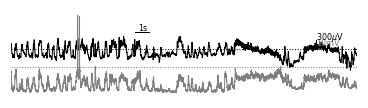

In [528]:
t0, width = 153.5, 25
spikes=50
vm_color=Grey
LFP_color='k'
Vm_bar = 10
LFP_bar=0.3
T_bar=1.
LFP_loc=-20
# fig, ax = show_vm_and_lfp(t, Vm, Extra, 153.5, 25, spikes=20,  Vm_bar=10, LFP_bar=0.3)

cond = (t>t0) & (t<t0+width)
fig, ax = figure(figsize=(.6,.15), left=.01, bottom=.1)
ax = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax.plot(t[cond][::100], Extra[cond].mean()-Extra[cond][::100]/LFP_bar*Vm_bar+LFP_loc, '-', lw=1,
                        color=LFP_color)
cond = cond & (Vm<spikes)
ax.plot(t[cond], Vm[cond], '-', color=vm_color, lw=1)
ax.plot([t[cond][0], t[cond][-1]], LFP_loc*np.ones(2), ':', color=LFP_color, lw=1)
ax.plot([t[cond][0], t[cond][-1]], -50*np.ones(2), ':', color=vm_color, lw=1)
# Tbar
ax.plot([t[cond][0]+T_bar+8, t[cond][0]+2*T_bar+8], [10, 10], 'k-', lw=1)
ax.annotate(str(int(T_bar))+'s', (t[cond][0]+T_bar+8+.2, 11), fontsize=FONTSIZE)
# Vm-LFP bar
ax.plot([t[cond][-1]-3*T_bar, t[cond][-1]-3*T_bar], [LFP_loc/5, LFP_loc/5-Vm_bar], 'k-', lw=1)
ax.annotate(str(int(Vm_bar))+'mV', (t[cond][-1]-3*T_bar, LFP_loc/5-Vm_bar), fontsize=FONTSIZE, color=vm_color)
ax.annotate(str(int(1e3*LFP_bar))+'$\mu$V', (t[cond][-1]-3*T_bar, LFP_loc/5),
            fontsize=FONTSIZE, color=LFP_color)
set_plot(ax, [], xlim=[t[cond][0], t[cond][-1]], xticks=[], yticks=[])

# for tt, c in zip([165, 155, 175.2], ['C0', 'C4', 'C1']): ax.plot([tt], [-70], '*', color=c, ms=14)
fig.savefig(desktop+'fig.svg')

# Wavelet analysis

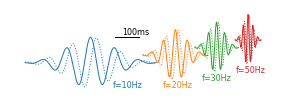

In [593]:
def Morlet_Wavelet(t, f, w0=6.):
    x = 2.*np.pi*f*t
    output = np.exp(1j * x)
    output *= np.exp(-0.5 * ((x/w0) ** 2)) #* np.pi ** (-0.25) # (Normalization comes later)
    return output # note the minus sign to have the 0 phase at bottom

def Morlet_Wavelet_Decay(f, w0=6.):
    return 2 ** .5 * (w0/(np.pi*f))

def from_fourier_to_morlet(freq):
    x = np.linspace(0.1/freq, 2.*freq, 1e3)
    return x[np.argmin((x-freq*(1-np.exp(-freq*x)))**2)]
    
def get_Morlet_of_right_size(f, dt, w0=6., with_t=False):
    Tmax = Morlet_Wavelet_Decay(f, w0=w0)
    t = np.arange(-int(Tmax/dt), int(Tmax/dt)+1)*dt
    if with_t:
        return t, Morlet_Wavelet(t, f, w0=w0)
    else:
        return Morlet_Wavelet(t, f, w0=w0)

fig1, ax = figure(figsize=(.46,.1), bottom=0.02, left=0.02)     
for i, f, xshift, xshift2, yshift2, yshift in zip(
        range(4), [10., 20,  30., 50.],
        [0, 3.5, 5.2, 6.5],
        [0.9, 3., 4.6, 6],
        [0., 0., 0.3, .6],
        np.arange(4)*.3):
    t, wvl = get_Morlet_of_right_size(f, 1e-3, with_t=True)
    ax.plot(t+.1*xshift, yshift+np.real(wvl),
         c='C'+str(i), lw=1)
    ax.plot(t+.1*xshift, yshift+np.imag(wvl), c='C'+str(i), ls=':',
            lw=1)
    ax.annotate('f='+str(int(f))+'Hz', (.1*xshift2, yshift2-1), color='C'+str(i), fontsize=FONTSIZE)
ax.plot([.1,.2], [1,1], 'k-', lw=1)
ax.annotate('100ms', (.13, 1.1), fontsize=FONTSIZE)    
set_plot(plt.gca(), [])
fig1.savefig('paper/Figures/wavelets_vis.svg')

## Finding the right normalization for CWT

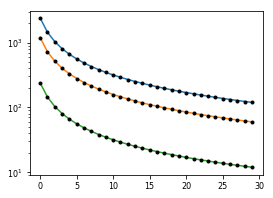

In [589]:
def norm_constant_num(freq, dt, w0=6.):
    Tmax = Morlet_Wavelet_Decay(freq, w0=w0)
    t = np.arange(-int(Tmax/dt), int(Tmax/dt)+1)*dt
    return np.abs(np.dot(np.cos(2.*np.pi*freq*t),\
                         np.conj(get_Morlet_of_right_size(freq, dt, w0=w0))))

def norm_constant_th(freq, dt, w0=6.):
    # from theoretical calculus:
    n = (w0/2./np.sqrt(2.*np.pi)/freq)*(1.+np.exp(-w0**2/2))
    # now need to account for the number of summed points (see the choice of wavelet extent)
    Tmax = Morlet_Wavelet_Decay(freq, w0=w0)
    # return np.sqrt(n) * np.sqrt(Tmax/dt) /np.sqrt(dt)*np.sqrt(2)/2
    return n/dt

# let's check that it matches the numerical estimate
fig, ax = figure(figsize=(.6,.3))
for dt in [1e-4, 2e-4, 1e-3]:
    ax.semilogy([norm_constant_th(f, dt, w0=6.) for f in np.linspace(5, 100, 30)])
    ax.semilogy([norm_constant_num(f, dt, w0=6.) for f in np.linspace(5, 100, 30)], 'ko', ms=3)

In [594]:
from scipy import signal
def my_cwt(data, frequencies, dt, w0=6.):
    
    output = np.zeros([len(frequencies), len(data)], dtype=np.complex)

    for ind, freq in enumerate(frequencies):
        wavelet_data = np.conj(get_Morlet_of_right_size(freq, dt, w0=w0))
        # the wavelets have different integrals
        # conv_number compensates for the number of summed points (i.e. also integral of wavelet)
        conv_number = signal.convolve(np.ones(len(data)), np.ones(len(wavelet_data)),
                                      mode='same')
        # the sliding mean that depends on the frequency
        sliding_mean = signal.convolve(data, np.ones(len(wavelet_data)),
                                       mode='same')/conv_number
        # the final convolution
        wavelet_data_norm = norm_constant_th(freq, dt, w0=w0)
        output[ind, :] = signal.convolve(data-sliding_mean+0.*1j, wavelet_data,
                                         mode='same')/wavelet_data_norm
        
    return output
    
noise_level = 0.
nfreq = 100

# temporal sampling
dt, tstop = 1e-4, 2.1
t = np.arange(int(tstop/dt))*dt

# ### artificially generated signal, transient oscillations
freq1, onset1, width1, amp1 = 40., 200e-3, 50e-3, 2.
freq2, onset2, width2, amp2 = 10., 700e-3, 150e-3, 2.
freq3, onset3, width3, amp3 = 60., 1200e-3, 50e-3, 2.
freq4, onset4, width4, amp4 = 40., 1700e-3, 150e-3, 1.
baseline = 0.
data  = baseline+\
    amp1*np.cos(2*np.pi*freq1*t)*np.exp(-(t-onset1)**2/2./width1**2)+\
    amp2*np.cos(2*np.pi*freq2*t)*np.exp(-(t-onset2)**2/2./width2**2)+\
    amp3*np.cos(2*np.pi*freq3*t)*np.exp(-(t-onset3)**2/2./width3**2)+\
    amp4*np.cos(2*np.pi*freq4*t)*np.exp(-(t-onset4)**2/2./width4**2)

# ### adding colored noise to test robustness
data += noise_level*np.convolve(np.exp(-np.arange(1000)*dt/400e-3),\
                    np.random.randn(len(t)), mode='same') # a slow one
data += noise_level*np.convolve(np.exp(-np.arange(1000)*dt/5e-3),\
                    np.random.randn(len(t)), mode='same') # a faster one

# Continuous Wavelet Transform analysis
freqs = np.linspace(1, 95, nfreq)
coefs = my_cwt(data, freqs, dt)

amp = np.abs(coefs)
cond = np.abs(coefs)<np.max(np.abs(coefs))*0.1
phase = np.angle(coefs)
phase[cond] = np.inf

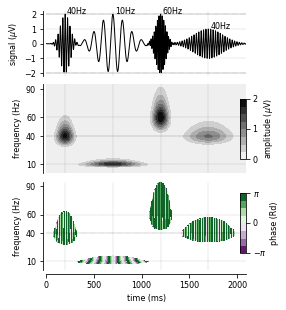

In [595]:
"""
a plot to illustrate the output of the wavelet analysis
"""
fig2, AX = figure(figsize=(0.46,0.36),
                 hspace=1.1, bottom=0.35, right=.9, left=.45,
                 axes_extents=[[[1,3]],[[1,4]], [[1,4]]])
# signal plot
plot(1e3*t, data, c='k', lw=1, ax=AX[0][0],\
     axes_args={'ylabel':'signal ($\mu$V)',
                'xlim':[1e3*t[0], 1e3*t[-1]],
                'yticks':baseline+np.arange(-2,3),
                'spines':['left']})
yyl = AX[0][0].get_ylim()
for f, a, tt in zip([freq1, freq2, freq3, freq4],\
                    [amp1, amp2, amp3, amp4],
                    [onset1, onset2, onset3, onset4]):
    AX[0][0].annotate(str(int(f))+'Hz', (1e3*tt+20, a+baseline), fontsize=FONTSIZE)
    AX[0][0].plot(1e3*tt+np.zeros(2), yyl, 'k:', lw=.2)
    for ax in [AX[1][0], AX[2][0]]:
        ax.plot(1e3*np.arange(2)*t[-1], [f, f], 'k:', lw=.2)
        ax.plot(1e3*tt+freqs*0, freqs, 'k:', lw=.2)
    AX[0][0].plot(1e3*np.arange(2)*t[-1], [a, a], 'k:', lw=.2)
    AX[0][0].plot(1e3*np.arange(2)*t[-1], [-a, -a], 'k:', lw=.2)

# time frequency power plot
c = AX[1][0].contourf(1e3*t, freqs, amp, cmap=mpl.cm.binary)
set_plot(AX[1][0], ['left'], xlim=[1e3*t[0], 1e3*t[-1]],
         ylabel='frequency (Hz)', yticks=[freq1, freq2, freq3, 90])
# inset with legend
acb = plt.axes([.85, .48, .02, .2])
cb = plt.colorbar(c, cax=acb, label='amplitude ($\mu$V)')
cb.set_ticks([0, 1, 2, 3])

# time frequency phase plot
c = AX[2][0].contourf(1e3*t, freqs, phase, cmap='PRGn')
set_plot(AX[2][0], xlim=[1e3*t[0], 1e3*t[-1]],
         xlabel='time (ms)', xticks=np.arange(5)*500,
         ylabel='frequency (Hz)', yticks=[freq1, freq2, freq3, 90])
# inset with legend
acb = plt.axes([.85, .17, .02, .2])
cb = plt.colorbar(c, cax=acb, label='phase (Rd)')
cb.set_ticks([-np.pi, 0, np.pi])
cb.set_ticklabels(['$-\pi$', '0', '$\pi$'])

In [596]:
from graphs.plot_export import put_list_of_figs_to_svg_fig
put_list_of_figs_to_svg_fig([fig1, fig2],
                            fig_name='paper/Figures/Fig_Wavelet_Demo.svg',
                            figsize=(0.335,0.34),
                            Props={'XCOORD':[-2,-5],
                                   'YCOORD':[-5,84],
                                   'XCOORD_LABELS':[-5, -5],
                                   'YCOORD_LABELS':[10, 78],
                                   'LABELS':['a','b']},
                            visualize=True)

# Application to electrophysiological recordings

In [529]:
"""
Loading a sample datafile for the awake
"""
from data_analysis.IO.load_data import load_file
data = load_file('../sparse_vs_balanced/'+\
                 'sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf')
cond = (data[0]>50) & (data[0]<150)
data_awake={'t':data[0][cond], 'Vm':data[1][1][cond], 'Extra':data[1][0][cond]}
data_awake['dt'] = data_awake['t'][1]-data_awake['t'][0]

In [23]:
"""
Loading a sample datafile for the anesthetized
"""
from data_analysis.IO.load_data import load_file
data = load_file(home+'DATA/Data_Ste_Zucca/2017_04_04/14_40_12_CCLAMP-WITH-CORTEX-EXTRA.h5')
cond = (data['t']>300) & (data['t']<400)
data_anesth={'t':data['t'][cond], 'Vm':data['Vm'][cond], 'Extra':data['ExtraCort'][cond]}
data_anesth['dt'] = data_anesth['t'][1]-data_anesth['t'][0]

In [597]:
from data_analysis.processing.signanalysis import gaussian_smoothing

def preprocess_LFP(data,
                   freqs = np.linspace(50, 300, 5),
                   new_dt = 5e-3, smoothing=20e-3, pLFP_unit='$\mu$V'):
    """
    performs continuous wavelet transform
    """
    data['W'] = my_cwt(data['Extra'], freqs, data['dt'])
    data['pLFP_freqs'] = freqs
    W2 = np.abs(data['W']).mean(axis=0)
    isubsmpl = int(round(new_dt/data['dt']))
    data['pLFP'] = gaussian_smoothing(\
                                      np.reshape(W2[:int(len(W2)/isubsmpl)*isubsmpl],
                                                 (int(len(W2)/isubsmpl),isubsmpl)).mean(axis=1),
                                      int(smoothing/new_dt))
    
    data['pLFP_unit']=pLFP_unit
    if pLFP_unit=='$\mu$V':
        data['pLFP'] *= 1e3
        
    data['new_t'] = np.arange(len(data['pLFP']))*new_dt+data['t'][0]
    data['new_dt'] = new_dt
    
#preprocess_LFP(data_anesth)
preprocess_LFP(data_awake)        

In [26]:
def plot_three_quant(data, tstart=-np.inf, tend=np.inf):
    cond = (data['t']>tstart) & (data['t']<tend)
    fig, AX = figure(axes=(3,1),figsize=(1.6,.4), hspace=.01)
    plot(data['t'][cond], data['Extra'][cond], ax=AX[0][0],
         axes_args={'ylabel':'$V_{ext}$ (mV)',
                    'xlim':[data['t'][cond][0], data['t'][cond][-1]], 'spines':['left']});
    plot(data['t'][cond], data['Vm'][cond], ax=AX[1][0],
         axes_args={'xlabel':'time (s)', 'ylabel':'$V_m$ (mV)',
                    'xlim':[data['t'][cond][0], data['t'][cond][-1]], 'spines':['left']});
    cond = (data['new_t']>tstart) & (data['new_t']<tend)
    plot(data['new_t'][cond], data['pLFP'][cond], ax=AX[2][0],
         axes_args={'xlabel':'time (s)', 'ylabel':'pLFP ('+data['pLFP_unit']+')',
                    'xlim':[data['new_t'][cond][0], data['new_t'][cond][-1]]}, c=Red);

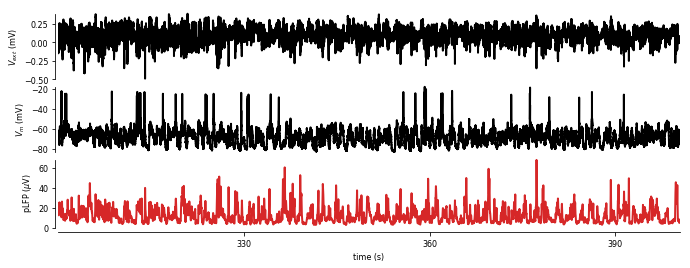

In [27]:
plot_three_quant(data_anesth)

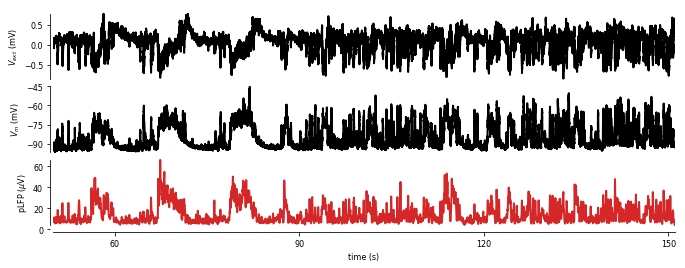

In [234]:
plot_three_quant(data_awake)

In [612]:
def compute_low_freqs_var(data, freqs = np.logspace(np.log(0.1)/np.log(10), 1, 40)):
    data['low_freqs'] = freqs
    data['W_low_freqs'] = my_cwt(data['pLFP'], freqs, data['new_dt'])    

#compute_low_freqs_var(data_anesth)    
compute_low_freqs_var(data_awake)    

## Finding the level of ~quiescent activity

In [598]:
from graphs.my_graph import *
from scipy.integrate import cumtrapz

def get_max_of_hist(data, nbins=300, smoothing=2):
    """
    maybe need to get more complex to identify the first maximum
    (e.g. Up and Down states case) 
    """
    binsize = (data['pLFP'].max()-data['pLFP'].min())/nbins
    Hist, be = np.histogram(data['pLFP'],
                            bins=np.concatenate([
                                np.arange(-2*smoothing,0)*binsize+data['pLFP'].min(),
                                np.arange(nbins)*binsize+data['pLFP'].min(),
                                np.arange(0,2*smoothing)*binsize+data['pLFP'].max()
                            ]), normed=True)
    i0 = np.argmax(gaussian_smoothing(Hist,smoothing))
    data['max_of_hist']=be[i0+1]
    data['noise_estimate']=np.std(data['pLFP'][data['pLFP']<data['max_of_hist']])
    data['hist_amp']=Hist[i0]
    return {'max_of_hist':be[i0],
            'noise_estimate':be[i0]-data['pLFP'].min(),
            'hist_amp':Hist[i0]}

get_max_of_hist(data_awake)
get_max_of_hist(data_anesth)

{'hist_amp': 0.091748365641054902,
 'max_of_hist': 5.3017155975561723,
 'noise_estimate': 2.3883096384884679}

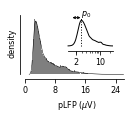

In [605]:
from graphs.my_graph import *
def show_histogram_of_pLFP(data, nbins=300, smoothing=2, XLIM=[3,24]):
    fig, ax = figure(figsize=(.19,.12), left=.4, bottom=1, right=1.1)
    hist(data['pLFP'], ax=ax, bins=nbins, normed=True, lw=0, facecolor=Grey)
    binsize = (data['pLFP'].max()-data['pLFP'].min())/nbins
    Hist, be = np.histogram(data['pLFP'],
                                     bins=np.concatenate([
                                         np.arange(-2*smoothing,0)*binsize+data['pLFP'].min(),
                                         np.arange(nbins)*binsize+data['pLFP'].min(),
                                         np.arange(0,2*smoothing)*binsize+data['pLFP'].max()
                                     ]), normed=True)
    result = get_max_of_hist(data, nbins=nbins, smoothing=smoothing)
    set_plot(ax, yticks=[],ylabel='density',
             xlabel='pLFP ('+data['pLFP_unit']+')')
    plot(.5*(be[1:]+be[:-1]), gaussian_smoothing(Hist,smoothing), ax=ax, lw=.5,
         axes_args={'yticks':[], 'ylabel':'density',
                    'xlabel':'pLFP ('+data['pLFP_unit']+')'})
    ax1 = plt.axes([0.5,0.6,0.42,0.32])
    ax1.plot(.5*(be[1:]+be[:-1]), gaussian_smoothing(Hist,smoothing), 'k-', lw=1)
    ax1.plot(result['max_of_hist']*np.ones(2), [0,1.1*result['hist_amp']], 'k:', lw=1)
    ax1.set_xscale('log')
    ax1.annotate(s='',
                 xy=(1.1*result['max_of_hist'],1.1*result['hist_amp']),
                 xytext=(result['max_of_hist']-1.2*result['noise_estimate'],1.1*result['hist_amp']),
                 arrowprops=dict(arrowstyle='<->, head_width=.1, head_length=0.2'))
    ax1.annotate('$p_0$', (result['max_of_hist'],1.18*result['hist_amp']), fontsize=FONTSIZE)
    ax1.annotate('$\sigma_p$', (result['max_of_hist']-3,1.18*result['hist_amp']), fontsize=FONTSIZE)
    set_plot(ax1,['bottom'],xlim=XLIM)
    set_plot(ax1,['bottom'],xlim=XLIM, yticks=[],xticks=[2,10], xticks_labels=['2','10'])
    # ax.legend(frameon=False, prop={'size':'x-small'})
    return fig

fig_hist = show_histogram_of_pLFP(data_awake, smoothing=3, XLIM=[1,24])
fig_hist.savefig(desktop+'fig.png', dpi=300)

In [606]:
def show_raw_LFP_large_scale(data,
                             Zooms=[],
                             Tbar=5, Tshift=0,
                             tstart=-np.inf, tend=np.inf):
    fig, AX = figure(axes=(2,1), figsize=(0.6,.16), hspace=0.01, left=.1)
    cond = (data['t']>tstart) & (data['t']<tend)
    AX[0][0].plot(data['t'][cond][::100], data['Extra'][cond][::100], 'k-', lw=1)
    y10, y11 = AX[0][0].get_ylim()
    AX[0][0].annotate(str(Tbar)+'s', (tstart+Tbar+Tshift+1, y10), fontsize=FONTSIZE)
    AX[0][0].plot(tstart+Tshift+np.arange(1,3)*Tbar, y10*np.ones(2), 'k-', lw=1)
    cond0 = (data['new_t']>tstart) & (data['new_t']<tend)
    AX[1][0].plot(data['new_t'][cond0], data['pLFP'][cond0], 'k-', lw=1, color=Brown)
    y20, y21 = AX[1][0].get_ylim()
    for i, (z1, z2) in enumerate(Zooms):
        AX[1][0].plot([z1, z2], y20*np.ones(2), '-', color=Grey)
        AX[1][0].annotate('('+'i'*(i+1)+')', (z1, y20), color=Grey, fontsize=FONTSIZE)
        AX[1][0].fill_between([z1, z2], y20*np.ones(2), y21*np.ones(2), color='k', alpha=.1)
        AX[0][0].fill_between([z1, z2], y10*np.ones(2), y11*np.ones(2), color='k', alpha=.1)
    set_plot(AX[0][0], ['left'],xlim=[data['t'][cond][0],data['t'][cond][-1]],
             ylabel='$V_{ext}$ (mV)')
    set_plot(AX[1][0], ['left'],xlim=[data['new_t'][cond0][0],data['new_t'][cond0][-1]],
             ylabel='pLFP ('+data['pLFP_unit']+')')
    return fig

def show_raw_LFP_and_pLFP(data, Zooms, pLFP_lim=[0,50],
                          Tbar=0.5, Tshift=.2, Tspace=.2, Vext_annot=0.5):
    fig, AX = figure(axes=(2,1), figsize=(0.6,.16), hspace=0.01, left=.1)
    tt=0
    for i, (z1, z2) in enumerate(Zooms):
        AX[0][0].plot([tt, tt+z2-z1], Vext_annot*np.ones(2), '-', color=Grey, lw=.2)
        AX[0][0].annotate('('+'i'*(i+1)+')', (tt, Vext_annot), color=Grey, fontsize=FONTSIZE)
        cond = (data['t']>z1) & (data['t']<z2)
        AX[0][0].plot(data['t'][cond][::4]-z1+tt, data['Extra'][cond][::4], 'k-', lw=1)
        cond = (data['new_t']>z1) & (data['new_t']<z2)
        AX[1][0].plot(data['new_t'][cond]-z1+tt, data['pLFP'][cond], '-', lw=1, color=Brown)
        tt+=z2-z1+Tspace
    set_plot(AX[0][0], ['left'],xlim=[0, tt-Tspace], ylabel='$V_{ext}$ (mV)')
    AX[1][0].plot([0, tt-Tshift],np.ones(2)*data['max_of_hist'], ':',c=Brown,lw=1)
    AX[1][0].annotate(str(int(1e3*Tbar))+'ms', (np.diff(Zooms[0])+Tshift, (pLFP_lim[1])), fontsize=FONTSIZE)
    AX[1][0].plot(np.diff(Zooms[0])+Tshift+np.arange(1,3)*Tbar, (pLFP_lim[1]-2)*np.ones(2), 'k-', lw=1)
    set_plot(AX[1][0], ['left'],xlim=[0, tt-Tspace],
             ylabel='pLFP ('+data['pLFP_unit']+')', ylim=pLFP_lim)
    return fig

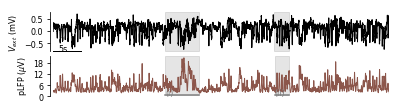

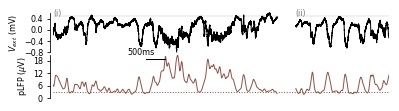

In [619]:
Zooms=[[110,116], [129.5,132]]
fig_full = show_raw_LFP_large_scale(data_awake, tstart=90, Zooms=Zooms, Tshift=-5)
fig_zoom = show_raw_LFP_and_pLFP(data_awake, Zooms, pLFP_lim=[0,21], Tshift=-4, Tspace=.5)

In [458]:
from graphs.plot_export import put_list_of_figs_to_svg_fig
put_list_of_figs_to_svg_fig([fig_full, fig_zoom],
                            fig_name='paper/Figures/Fig.svg',
                            figsize=(0.5,0.3),
                            Props={'XCOORD':[32,32],
                                   'YCOORD':[10,100],
                                   'XCOORD_LABELS':[0, 0],
                                   'YCOORD_LABELS':[5, 78],
                                   'LABELS':['a','b']},
                            visualize=True)

In [620]:

def show_Vm_pLFP_spectrogram(data, tstart=-np.inf, tend=np.inf):
    fig, AX = figure(axes_extents=[[[1,1]],[[1,1]],[[1,2]],[[1,2]]],figsize=(0.6,.6), hspace=0.01)
    cond = (data['t']>tstart) & (data['t']<tend)
    plot(data['t'][cond], data['Vm'][cond], ax=AX[0][0], lw=1,
         axes_args={'spines':['left'],'xlim':[data['t'][cond][0],data['t'][cond][-1]], 'ylabel':'$V_m$ (mV)'})
    cond = (data['new_t']>tstart) & (data['new_t']<tend)
    ax=AX[1][0].plot(data['new_t'][cond], data['new_t'][cond]*0+data['max_of_hist'], 'k:', lw=0.5)
    plot(data['new_t'][cond], data['pLFP'][cond], ax=AX[1][0], c=Brown, lw=1,
         axes_args={'spines':['left'],'xlim':[data['new_t'][cond][0],data['new_t'][cond][-1]],
                    'ylabel':'pLFP ('+data['pLFP_unit']+')'})
    c = AX[2][0].contourf(data['new_t'][cond], data['low_freqs'], np.abs(data['W_low_freqs'][:,cond]),
                          cmap=mpl.cm.binary)
    AX[2][0].set_yscale('log')
    set_plot(AX[2][0], ['left'], yticks=[0.1, 0.2, 0.5, 1, 2, 5, 10], ylim=[0.1, 10],
             yticks_labels=['', '0.2', '0.5', '1', '2', '5', ''], ylabel='freq. (Hz)')
    c = AX[3][0].contourf(data['new_t'][cond], data['low_freqs'], np.angle(data['W_low_freqs'][:,cond]), cmap='PRGn')
    AX[3][0].set_yscale('log')
    set_plot(AX[3][0], yticks=[0.1, 0.2, 0.5, 1, 2, 5, 10], ylim=[0.1, 10],
             yticks_labels=['', '0.2', '0.5', '1', '2', '5', ''], ylabel='freq. (Hz)')


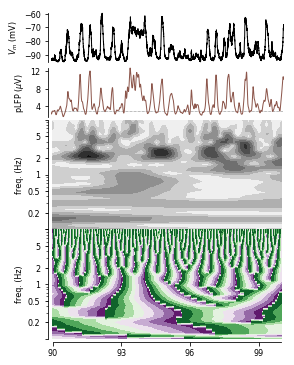

In [621]:
show_Vm_pLFP_spectrogram(data_awake, tstart=90, tend=100)

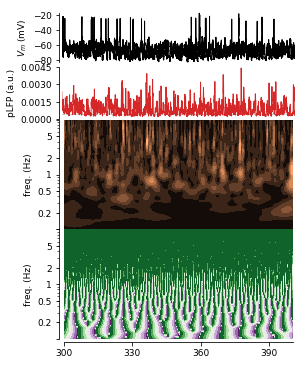

In [459]:
show_Vm_pLFP_spectrogram(data_anesth)

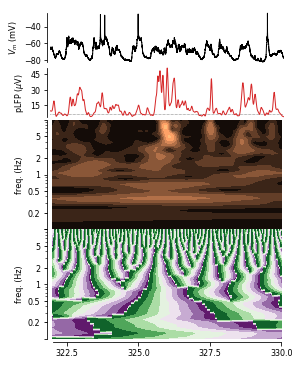

In [39]:
show_Vm_pLFP_spectrogram(data_anesth, tstart=322, tend=330)

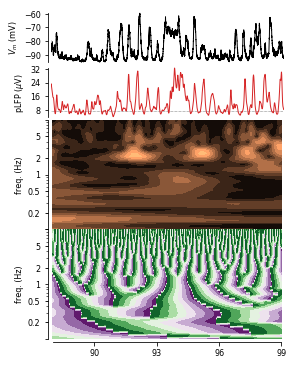

In [40]:
show_Vm_pLFP_spectrogram(data_awake, tstart=88, tend=99)

## Finding the level of ~quiescent activity

Idea: we look for the strongly oscillating samples and we take the
level found in the down phase of those

In [63]:
from graphs.my_graph import *
from scipy.integrate import cumtrapz

def compute_threshold_for_highly_oscill_act(data, threshold=0.95):
    hist, bins = np.histogram(np.abs(data['W_low_freqs']).mean(axis=0), 1000, normed=True)
    return bins[1:][np.argmin((cumtrapz(hist, bins[1:])-threshold)**2)]

def plot_histogram_of_low_freq_power(data, threshold=0.99):
    CUMPROD, BINS = [], []
    for i in range(len(data['low_freqs'])):
        hist, bins = np.histogram(np.abs(data['W_low_freqs'][i,:]), 100, normed=True)
        CUMPROD.append(cumtrapz(hist, bins[1:]))
        BINS.append(bins[2:])
    # plot(X=BINS, Y=CUMPROD, ax=plt.gca(), lw=1, bar_legend_args={}, bar_label='freq')
    plot(X=BINS, Y=CUMPROD, ax=plt.gca(), lw=1)
    hist, bins = np.histogram(np.abs(data['W_low_freqs']).mean(axis=0), 10000, normed=True)
    plot(bins[2:], cumtrapz(hist, bins[1:]), ax=plt.gca(), c='k', lw=3)
    thresh = compute_threshold_for_highly_oscill_act(data, threshold=threshold)
    plt.plot([0, thresh, thresh], [threshold, threshold, 0], 'k--')

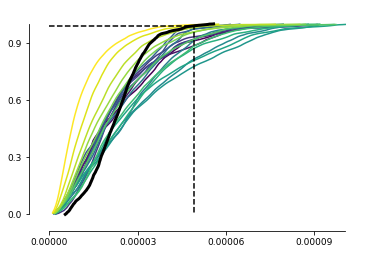

In [64]:
plot_histogram_of_low_freq_power(data_awake)

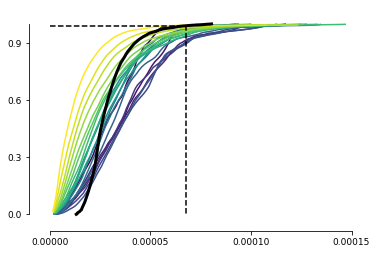

In [65]:
plot_histogram_of_low_freq_power(data_anesth)

In [622]:
def find_times_of_low_phase(data, power_threshold=0.99, phase_extent=np.pi/12):

    pow_thresh = data['max_of_hist'] #compute_threshold_for_highly_oscill_act(data, threshold=power_threshold)
    times, indices = [], []
    for i in range(len(data['new_t'])):
        # find freq of max power
        i0 = np.argmax(np.abs(data['W_low_freqs'][:,i]))
        # if np.abs(np.angle(data['W_low_freqs'][i0,i]))>np.pi/2.:
        cond = (np.abs(np.angle(data['W_low_freqs'][i0,i]))<phase_extent) and\
            (np.abs(data['W_low_freqs'][i0,i])>pow_thresh)
        if cond:
            indices.append(i)
            times.append(data['new_t'][i])
    data['ind_low_phase'] = indices
    data['times_low_phase'] = times

find_times_of_low_phase(data_anesth)
find_times_of_low_phase(data_awake)

In [623]:
def comparison_plot(data):
    figure()
    plt.bar([0], np.mean(data['pLFP']), yerr=np.std(data['pLFP']), color='grey')
    plt.bar([1], np.mean(data['pLFP'][data['ind_low_phase']]),\
            yerr=np.std(data['pLFP'][data['ind_low_phase']]), color=Brown)

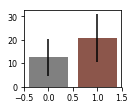

In [624]:
find_times_of_low_phase(data_anesth, phase_extent=np.pi/100., power_threshold=0.99)
comparison_plot(data_anesth)

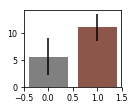

In [625]:
find_times_of_low_phase(data_awake, phase_extent=np.pi/1000., power_threshold=0.9999)
comparison_plot(data_awake)

In [626]:
def see_low_times_of_low_phase_with_Vm(data, zoom=[-np.inf, np.inf]):
    fig, ax = figure(figsize=(1,.3))[1][0][0]
    cond = (data['t']>zoom[0]) & (data['t']<zoom[1])
    plot(data['t'][cond][::10], data['Vm'][cond][::10], lw=1, ax=ax)
    cond = (data['new_t'][data['ind_low_phase']]>zoom[0]) & (data['new_t'][data['ind_low_phase']]<zoom[1])
    scatter(data['new_t'][data['ind_low_phase']][cond],\
            -80.*np.ones(len(np.array(data['ind_low_phase'])[cond])), color=Red, ax=ax)

TypeError: 'AxesSubplot' object does not support indexing

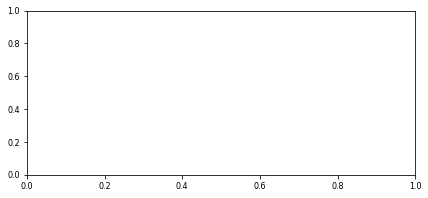

TypeError: 'AxesSubplot' object does not support indexing

In [627]:
see_low_times_of_low_phase_with_Vm(data_anesth, zoom=[320, 340])

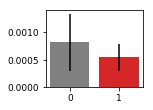

In [458]:
find_times_of_low_phase(data_anesth)
comparison_plot(data_anesth)

In [252]:
power_bins = np.digitize(np.abs(W).mean(axis=0), 100)

(<matplotlib.figure.Figure at 0x1a9a916080>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a10b45710>)

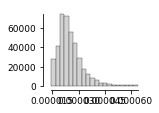

In [247]:
hist(np.abs(W).mean(axis=0))

In [206]:
freqs

array([  0.1       ,   0.1274275 ,   0.16237767,   0.20691381,
         0.26366509,   0.33598183,   0.42813324,   0.54555948,
         0.6951928 ,   0.88586679,   1.12883789,   1.43844989,
         1.83298071,   2.33572147,   2.97635144,   3.79269019,
         4.83293024,   6.15848211,   7.8475997 ,  10.        ])

(<matplotlib.figure.Figure at 0x1a119f3e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a9d280dd8>)

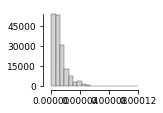

In [204]:
hist(np.abs(W[-1,:]))

(<matplotlib.figure.Figure at 0x1a1047fa90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1042b898>)

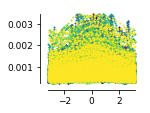

In [200]:
scatter(X=np.angle(W), Y=[data_awake['hGamma_Act'] for i in range(len(W))], ms=1)

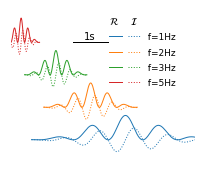

In [303]:
# ewrwkejr
def Custom_Wavelet(t, f, w0=6.):
    x = 2*np.pi*f*t
    output = np.exp(1j * x)
    output = (np.exp(1j * x)+1)/2.*np.exp(-0.5 * ((x/w0) ** 2)) * np.pi ** (-0.25)
    # return (np.real(output)+.5)/2. # note the minus sign to have the 0 phase at bottom
    # return np.real(output)**2 # note the minus sign to have the 0 phase at bottom
    return output # note the minus sign to have the 0 phase at bottom

def Custom_Wavelet_Decay(f, w0=6.):
    return 2 ** .5 * (w0/(np.pi*f))

def from_fourier_to_morlet(freq):
    x = np.linspace(0.1/freq, 2.*freq, 1e3)
    return x[np.argmin((x-freq*(1-np.exp(-freq*x)))**2)]
    
def get_Custom_of_right_size(f, dt, w0=6, with_t=False):
    Tmax = Custom_Wavelet_Decay(f, w0=w0)
    t = np.arange(-int(Tmax/dt), int(Tmax/dt))*dt
    if with_t:
        return t, Custom_Wavelet(t, f, w0=w0)
    else:
        return Custom_Wavelet(t, f, w0=w0)

fig, ax = figure(figsize=(.32,.2), bottom=0.02, left=0.02)     
for i, f in enumerate([1., 2,  3., 5.]):
    t, wvl = get_Custom_of_right_size(f, 0.01, with_t=True)
    plot(t-i, i+np.real(wvl),
         c='C'+str(i), ax=ax, lw=1,
         label='  f='+str(int(f))+'Hz')
    plot(t-i, i+np.imag(wvl), c='C'+str(i), ls=':',
         ax=ax, lw=1,label=' ')
# ax.legend(frameon=False, loc=1)
ax.plot([-1.5,-.5], [3., 3.], 'k-', lw=1)
ax.annotate('1s', (-1.2, 3.1))    
ax.grid('on')
set_plot(plt.gca(), [], ylim=[-1,4], xlim=[-i-.3,2])

LABELS = [ax.lines[i].get_label() for i in range(len(ax.lines))]
leg = plt.legend(ax.lines[0:-1:2]+ax.lines[1::2], LABELS[1:-1:2]+LABELS[::2],
                 loc=(.5,.5), frameon=False,
             title=r'$\mathcal{R}$    $\mathcal{I}$            ',  
             ncol=2, numpoints=3, handletextpad=-0.2, labelspacing=0.7, columnspacing=0.001)
#save_on_desktop(fig, figname='fig.png')

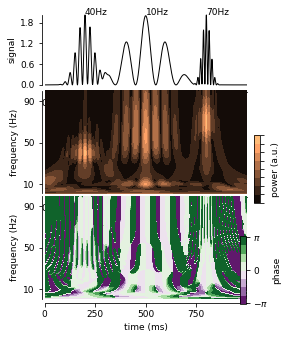

In [315]:
from scipy import signal
def my_custom_transform(data, frequencies, dt):
    
    output = np.zeros([len(frequencies), len(data)], dtype=np.complex)

    for ind, freq in enumerate(frequencies):
        # wavelet_data = np.conj(get_Custom_of_right_size(freq, dt))
        wavelet_data = get_Custom_of_right_size(freq, dt)
        # the wavelets have different integrals
        # conv_number compensates for the number of summed points (i.e. also integral of wavelet)
        conv_number = signal.convolve(np.ones(len(data))+0.*1j, np.ones(len(wavelet_data)),
                                      mode='same')
        # the sliding mean that depends on the frequency
        sliding_mean = signal.convolve(data+0.*1j, np.ones(len(wavelet_data)),
                                       mode='same')/conv_number
        # the final convolution
        output[ind, :] = signal.convolve(data-sliding_mean+0.*1j, wavelet_data,
                                         mode='same')/conv_number
    return output
    
def illustration_plot(t, freqs, data,
                      coefs, phase, dt,
                      tstop, freq1, freq2, freq3,
                      phase_colormap='PRGn',
                      power_colormap=copper):
    """
    a plot to illustrate the output of the wavelet analysis
    """
    fig, AX = figure(figsize=(0.46,0.4),
                     hspace=0.05, wspace=0.01, bottom=0.35, right=.9, left=.43,
                     axes_extents=[[[1,3]],[[1,4]], [[1,4]]])
    # signal plot
    plot(1e3*t, data, c='k', lw=1, ax=AX[0][0],\
         axes_args={'ylabel':'signal', 'xlim':[1e3*t[0], 1e3*t[-1]]})
    for f, tt in zip([freq2, freq1, freq3], [200,500,800]):
        AX[0][0].annotate(str(int(f))+'Hz', (tt, data.max()), fontsize=FONTSIZE)

    # time frequency power plot
    c = AX[1][0].contourf(1e3*t, freqs, coefs, cmap=copper)
    set_plot(AX[1][0], xlim=[1e3*t[0], 1e3*t[-1]],
             ylabel='frequency (Hz)', yticks=[10, 50, 90])
    # inset with legend
    acb = plt.axes([.9, .4, .02, .2])
    cb = plt.colorbar(c, cax=acb, label='power (a.u.)')
    cb.set_ticklabels([])

    # time frequency phase plot
    c = AX[2][0].contourf(1e3*t, freqs, phase, cmap=phase_colormap)
    set_plot(AX[2][0], xlim=[1e3*t[0], 1e3*t[-1]],
             ylabel='frequency (Hz)', yticks=[10, 50, 90],
             xlabel='time (ms)')
    # inset with legend
    acb = plt.axes([.85, .1, .02, .2])
    cb = plt.colorbar(c, cax=acb, label='phase')
    cb.set_ticks([-np.pi, 0, np.pi])
    cb.set_ticklabels(['$-\pi$', '0', '$\pi$'])
    return fig

noise_level = 0.
nfreq = 100

# temporal sampling
dt, tstop = 1e-4, 1.
t = np.arange(int(tstop/dt))*dt

# ### artificially generated signal, transient oscillations
freq1, width1, freq2, width2, freq3, width3 = 10., 100e-3, 40., 40e-3, 70., 20e-3
data  = (1+np.cos(2*np.pi*freq1*t))*np.exp(-(t-.5)**2/2./width1**2)+\
        (1+np.cos(2*np.pi*freq2*t))*np.exp(-(t-.2)**2/2./width2**2)+\
        (1+np.cos(2*np.pi*freq3*t))*np.exp(-(t-.8)**2/2./width3**2)

# ### adding colored noise to test robustness
data += noise_level*np.convolve(np.exp(-np.arange(1000)*dt/400e-3),\
                    np.random.randn(len(t)), mode='same') # a slow one
data += noise_level*np.convolve(np.exp(-np.arange(1000)*dt/5e-3),\
                    np.random.randn(len(t)), mode='same') # a faster one

# Continuous Wavelet Transform analysis
freqs = np.linspace(1, 100, nfreq)
coefs = my_custom_transform(data, freqs, dt)

phase = np.angle(coefs)
# cond = np.abs(coefs)<np.max(np.abs(coefs))*0.1
# phase[cond] = np.inf
fig = illustration_plot(t, freqs, data, np.abs(coefs), phase, dt, tstop, freq1, freq2, freq3);
#save_on_desktop(fig, figname='fig.png')